# OE Regression Modeling 

Procedure:
- Loads `oe_detailed` from `../data/processed/oe_detailed.parquet`
- Engineers features:
  - `log_time`, `log_distance`, `log_weight`, `log_cube`, `log_quantity`
  - WorkCode one-hot (3 codes expected; works for any number)
  - Top-10 Aisle coding (`Aisle_top10`)
  - `Level` as categorical (`Level_cat`)
- Splits by 7d-1d
- Fits:
  1) Simple OLS: `log_time ~ log_distance + log_weight + WorkCode
  2) All-features OLS (all engineered features)
  3) Stepwise regression (AIC-based forward selection)
- Reports metrics, coefficients, and diagnostics plots.


In [63]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

SPLIT_DATE = pd.to_datetime("2025-11-23")
OE_PATH = Path("../data/processed/oe_detailed.parquet")
PICKTIME_PATH = Path("../data/processed/product_pick_times.csv")  # adjust if needed

print("OE_PATH exists:", OE_PATH.exists(), OE_PATH)
print("PICKTIME_PATH exists:", PICKTIME_PATH.exists(), PICKTIME_PATH)


OE_PATH exists: True ../data/processed/oe_detailed.parquet
PICKTIME_PATH exists: True ../data/processed/product_pick_times.csv


In [64]:
# Load oe_detailed
oe = pd.read_parquet(OE_PATH)

# Ensure Timestamp is datetime
oe["Timestamp"] = pd.to_datetime(oe.get("Timestamp"), errors="coerce")
oe = oe.dropna(subset=["Timestamp"]).copy()

print("oe shape:", oe.shape)
print("Timestamp range:", oe["Timestamp"].min(), "->", oe["Timestamp"].max())
oe.head()


oe shape: (94402, 30)
Timestamp range: 2025-09-08 11:42:18.630000 -> 2025-12-02 23:15:28.677000


,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID,Prev_Timestamp,Prev_LocationID,Time_Delta_sec,ProductCode,UnitOfMeasure,Weight,Cube,Aisle,Bay,Level,Slot,Prev_Aisle,Prev_Bay,Prev_Level,Prev_Slot,Aisle2,Bay2,Prev_Aisle2,Prev_Bay2,LocKey,PrevLocKey,Travel_Distance
0,PickPut,143,30,7717848,49658,160,2025-09-08 12:11:50.830,35192,NaT,<NA>,NaN,4600CM5200,PK,0.0113,0.005,40,19,2,2,None,<NA>,<NA>,<NA>,40,19,<NA>,<NA>,40|19|||,<NA>|<NA>|||,NaN
1,PickPut,143,30,7717860,460,50,2025-09-08 12:12:18.127,422,2025-09-08 12:11:50.830,35192,27.297,6487PBBSJC,EA,0.0300,0.016,40,18,2,1,40,19,2,2,40,18,40,19,40|18|||,40|19|||,21.0
2,PickPut,143,30,7717908,460,100,2025-09-08 12:15:46.650,422,2025-09-08 12:12:18.127,422,208.523,6487PBBSJC,EA,0.0300,0.016,40,18,2,1,40,18,2,1,40,18,40,18,40|18|||,40|18|||,0.0
3,PickPut,143,30,7717921,44547,13,2025-09-08 12:16:30.470,10743,2025-09-08 12:15:46.650,422,43.820,635806236Y,EA,0.5000,0.139,40,18,2,2,40,18,2,1,40,18,40,18,40|18|||,40|18|||,0.0
4,PickPut,143,30,7717920,44547,13,2025-09-08 12:18:00.970,10743,2025-09-08 12:16:30.470,10743,90.500,635806236Y,EA,0.5000,0.139,40,18,2,2,40,18,2,2,40,18,40,18,40|18|||,40|18|||,0.0


In [65]:
# Load product_pick_times (if available)
product_pick_times = None
if PICKTIME_PATH.exists():
    product_pick_times = pd.read_csv(PICKTIME_PATH)
    print("product_pick_times shape:", product_pick_times.shape)
    display(product_pick_times.head())
else:
    print("WARNING: product_pick_times.csv not found. log_picktime will be NA.")


product_pick_times shape: (2195, 5)


,ProductID,n_pairs,avg_pick_time_sec,median_pick_time_sec,std_pick_time_sec
0,1,294,3.716493,0.2835,34.117869
1,3,95,15.635168,9.0570,16.567655
2,4,37,17.089459,17.6200,12.933894
3,7,5,15.023200,2.3260,26.563315
4,8,2,21.388500,21.3885,29.337153


In [66]:
# ---------- Feature engineering ----------
df = oe.copy()

# Ensure numerics
for col in ["Time_Delta_sec", "Weight", "Cube", "Quantity"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Filter for log viability
df = df[
    (df["Time_Delta_sec"] > 0) &
    (df["Travel_Distance"] > 0) &
    (df["Weight"] > 0) &
    (df["Cube"] > 0)
].copy()

# Logs
df["log_time"] = np.log(df["Time_Delta_sec"])
df["log_distance"] = np.log(df["Travel_Distance"])
df["log_weight"] = np.log(df["Weight"])
df["log_cube"] = np.log(df["Cube"])

# log(quantity)
if "Quantity" in df.columns:
    if (df["Quantity"] <= 0).any():
        df["log_quantity"] = np.log1p(df["Quantity"])
    else:
        df["log_quantity"] = np.log(df["Quantity"])
else:
    df["log_quantity"] = np.nan

# WorkCode
df["WorkCode"] = df["WorkCode"].astype(str)

# log_picktime join (optional)
df["log_picktime"] = np.nan
if product_pick_times is not None and "ProductID" in df.columns:
    # choose a pick-time column
    cand = [c for c in product_pick_times.columns if c.lower() in ["avg_pick_time_sec","avg_time_sec","avg_pick_time","avg_pick_sec"]]
    if not cand:
        cand = [c for c in product_pick_times.columns if "avg" in c.lower() and "time" in c.lower()]
    if cand:
        pick_col = cand[0]
        tmp = product_pick_times[["ProductID", pick_col]].copy()
        tmp[pick_col] = pd.to_numeric(tmp[pick_col], errors="coerce")
        tmp = tmp[tmp[pick_col] > 0].copy()
        tmp["log_picktime"] = np.log(tmp[pick_col])
        df = df.merge(tmp[["ProductID", "log_picktime"]], on="ProductID", how="left")
    else:
        print("WARNING: Could not infer average pick-time column. Columns:", product_pick_times.columns.tolist())

# Aisle top-10 coding
df["Aisle"] = df["Aisle"].astype(str)
top10_aisles = df["Aisle"].value_counts().head(10).index.tolist()
df["Aisle_top10"] = df["Aisle"].where(df["Aisle"].isin(top10_aisles), other="Other")

# Level categorical
df["Level"] = pd.to_numeric(df["Level"], errors="coerce").astype("Int64")
df["Level_cat"] = df["Level"].astype(str)

# Time of day (bucket)
df["hour"] = df["Timestamp"].dt.hour.astype(int)
def tod_bucket(h):
    if 6 <= h < 12:
        return "6-12"
    elif 12 <= h < 16:
        return "12-4"
    elif 16 <= h < 20:
        return "4-8"
    elif 20 <= h < 24:
        return "8-12"
    else:
        return "after_midnight"
df["time_of_day"] = df["hour"].apply(tod_bucket)

print("Engineered df shape:", df.shape)
df.head()


Engineered df shape: (48558, 41)


,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID,Prev_Timestamp,Prev_LocationID,Time_Delta_sec,ProductCode,UnitOfMeasure,Weight,Cube,Aisle,Bay,Level,Slot,Prev_Aisle,Prev_Bay,Prev_Level,Prev_Slot,Aisle2,Bay2,Prev_Aisle2,Prev_Bay2,LocKey,PrevLocKey,Travel_Distance,log_time,log_distance,log_weight,log_cube,log_quantity,log_picktime_x,log_picktime_y,Aisle_top10,Level_cat,hour,time_of_day
0,PickPut,143,30,7717860,460,50,2025-09-08 12:12:18.127,422,2025-09-08 12:11:50.830,35192,27.297,6487PBBSJC,EA,0.0300,0.016,40,18,2,1,40,19,2,2,40,18,40,19,40|18|||,40|19|||,21.0,3.306777,3.044522,-3.506558,-4.135167,3.912023,NaN,3.725999,40,2,12,12-4
1,PickPut,143,30,7717815,191,8,2025-09-08 12:18:45.173,2985,2025-09-08 12:18:00.970,10743,44.203,0723306546,BX,1.4500,0.137,40,16,2,4,40,18,2,2,40,16,40,18,40|16|||,40|18|||,43.0,3.788793,3.761200,0.371564,-1.987774,2.079442,NaN,3.715937,40,2,12,12-4
2,PickPut,143,30,7717815,40501,48,2025-09-08 12:21:25.467,157913,2025-09-08 12:20:42.060,2985,43.407,3583AXABLEND,EA,0.0625,0.012,40,14,2,4,40,16,2,4,40,14,40,16,40|14|||,40|16|||,43.0,3.770621,3.761200,-2.772589,-4.422849,3.871201,NaN,2.962744,40,2,12,12-4
3,PickPut,143,30,7717990,20147,8,2025-09-08 12:23:53.730,3966,2025-09-08 12:21:33.390,157913,140.340,3474POSPUSTD,EA,2.0000,0.191,40,18,1,3,40,14,2,4,40,18,40,14,40|18|||,40|14|||,86.0,4.944068,4.454347,0.693147,-1.655482,2.079442,NaN,3.648563,40,1,12,12-4
4,PickPut,143,30,7717991,7551,4,2025-09-08 12:26:28.270,18911,2025-09-08 12:26:02.440,422,25.830,60340M5172,EA,0.5500,0.172,40,14,6,3,40,18,2,1,40,14,40,18,40|14|||,40|18|||,86.0,3.251537,4.454347,-0.597837,-1.760261,1.386294,NaN,NaN,40,6,12,12-4


In [67]:
# ---------- Train/Test split (data-driven 90% cutoff at 3am) ----------
# We define an "analysis day" that starts at 03:00 and ends at 02:59 next day.
# 1) Assign each row to an analysis day: (Timestamp - 3h).date
# 2) Count rows per day, compute cumulative share by day (sorted chronologically)
# 3) Choose the first day where cumulative share >= 90%
# 4) Cutoff timestamp = chosen_day at 03:00

# Day stats (min/max timestamp per analysis day)
df["analysis_day"] = (df["Timestamp"] - pd.Timedelta(hours=3)).dt.date

day_stats = (
    df.groupby("analysis_day")["Timestamp"]
      .agg(day_min="min", day_max="max", n_rows="size")
      .reset_index()
      .sort_values("analysis_day")
)

day_stats["cum_rows"] = day_stats["n_rows"].cumsum()
day_stats["cum_share"] = day_stats["cum_rows"] / day_stats["n_rows"].sum()

# Find 90% day
split_day = day_stats.loc[day_stats["cum_share"] >= 0.90, "analysis_day"].iloc[0]
split_ts = pd.Timestamp(split_day) + pd.Timedelta(hours=3)

print("Chosen split_day (analysis_day):", split_day)
print("Cutoff timestamp (split_ts):", split_ts)
display(day_stats.tail(10))

train_df = df[df["Timestamp"] < split_ts].copy()
test_df  = df[df["Timestamp"] >= split_ts].copy()

print("Train rows:", len(train_df), "Test rows:", len(test_df))
print("Train date range:", train_df["Timestamp"].min(), "->", train_df["Timestamp"].max())
print("Test date range:", test_df["Timestamp"].min(), "->", test_df["Timestamp"].max())



Chosen split_day (analysis_day): 2025-12-02
Cutoff timestamp (split_ts): 2025-12-02 03:00:00


,analysis_day,day_min,day_max,n_rows,cum_rows,cum_share
0,2025-09-08,2025-09-08 11:43:00.333,2025-09-09 00:00:37.770,7043,7043,0.145043
1,2025-09-09,2025-09-09 11:42:15.883,2025-09-09 20:25:06.360,5324,12367,0.254685
2,2025-11-10,2025-11-10 11:39:42.330,2025-11-10 23:22:43.627,7338,19705,0.405803
3,2025-11-11,2025-11-11 11:38:38.970,2025-11-11 21:20:50.410,5162,24867,0.512109
4,2025-11-12,2025-11-12 11:46:24.723,2025-11-12 22:47:26.783,5429,30296,0.623914
5,2025-11-13,2025-11-13 11:46:47.430,2025-11-13 21:57:38.327,5512,35808,0.737427
6,2025-12-01,2025-12-01 11:43:13.633,2025-12-02 01:34:01.790,7713,43521,0.896268
7,2025-12-02,2025-12-02 11:46:29.210,2025-12-02 23:15:28.677,5037,48558,1.000000


Train rows: 43521 Test rows: 5037
Train date range: 2025-09-08 11:43:00.333000 -> 2025-12-02 01:34:01.790000
Test date range: 2025-12-02 11:46:29.210000 -> 2025-12-02 23:15:28.677000


In [68]:
# Helpers: design matrices, fit OLS(QR), evaluate, coefficient table, diagnostics

def build_Xy(df_in, feature_cols, cat_cols=None, drop_first=True, add_const=True):
    d = df_in.copy()
    y = d["log_time"].astype(float)
    X = d[feature_cols].copy()
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=drop_first)
    X = X.replace([np.inf, -np.inf], np.nan).apply(pd.to_numeric, errors="coerce").fillna(0).astype(float)
    if add_const:
        X = sm.add_constant(X, has_constant="add")
    return X, y

def fit_ols_qr(X, y):
    return sm.OLS(y, X).fit(method="qr")

def eval_model(model, X_test, y_test, label="model"):
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    print(f"[{label}] Test RMSE (log): {rmse:.4f} | R^2: {r2:.4f}")
    return pred, rmse, r2

def coef_table(model):
    return pd.DataFrame({
        "variable": model.params.index,
        "coefficient": model.params.values,
        "p_value": model.pvalues.values
    }).sort_values("p_value")

def diag_plots(y_true, y_pred, title_prefix=""):
    resid = y_true - y_pred
    fitted = y_pred
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].scatter(fitted, resid, alpha=0.3, s=15)
    axes[0].axhline(0, linestyle="--")
    axes[0].set_title(f"{title_prefix} Residuals vs Fitted")
    axes[0].set_xlabel("Fitted (log_time)")
    axes[0].set_ylabel("Residuals")

    axes[1].scatter(fitted, y_true, alpha=0.3, s=15)
    lims = [min(fitted.min(), y_true.min()), max(fitted.max(), y_true.max())]
    axes[1].plot(lims, lims, "r--")
    axes[1].set_title(f"{title_prefix} Actual vs Fitted")
    axes[1].set_xlabel("Fitted (log_time)")
    axes[1].set_ylabel("Actual (log_time)")

    sm.qqplot(resid, line="45", ax=axes[2])
    axes[2].set_title(f"{title_prefix} Q-Q Plot (Residuals)")

    plt.tight_layout()
    plt.show()


                            OLS Regression Results                            
Dep. Variable:               log_time   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     3092.
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        02:07:40   Log-Likelihood:                -54622.
No. Observations:               43521   AIC:                         1.093e+05
Df Residuals:                   43516   BIC:                         1.093e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.1637      0.028     78.413   

,variable,coefficient,p_value
0,const,2.163695,0.000000e+00
1,log_distance,0.393062,0.000000e+00
4,WorkCode_30,0.427602,9.915471e-115
3,WorkCode_20,0.075211,2.110818e-05
2,log_weight,0.005751,3.911669e-02


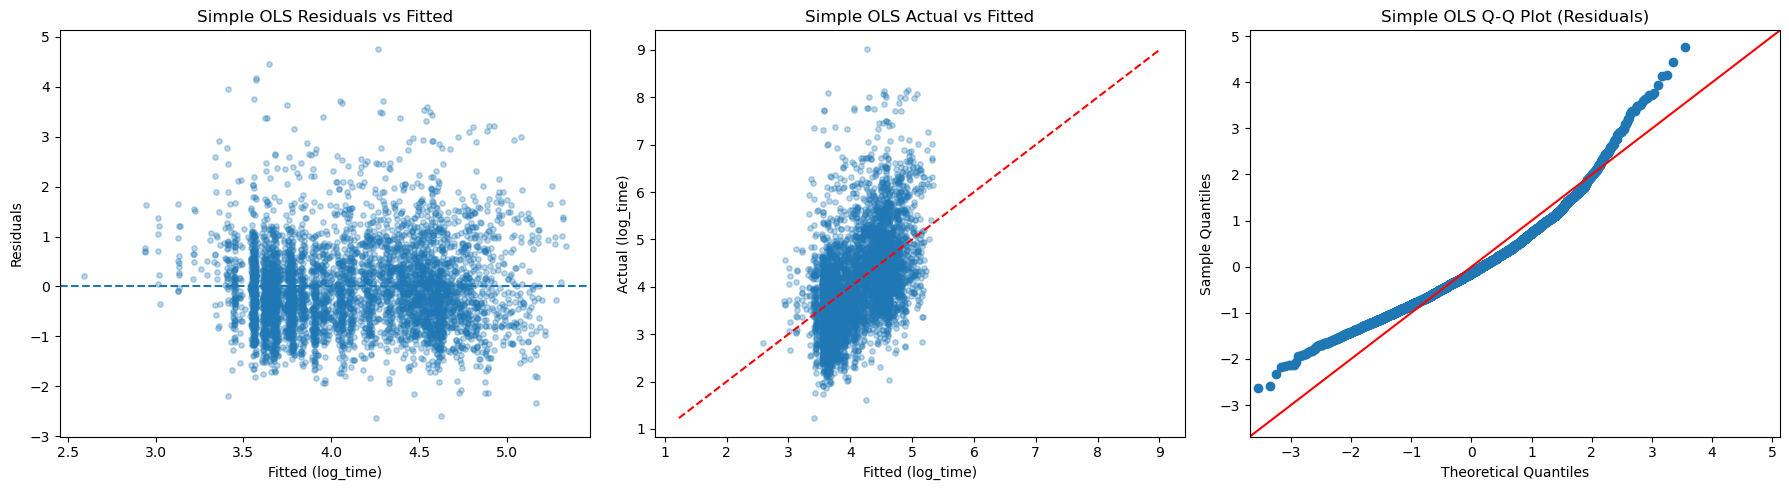

In [69]:
# ---------- Model 1: Simple OLS ----------
# log_time ~ log_distance + log_weight + WorkCode + log_picktime

simple_features = ["log_distance", "log_weight", "WorkCode"]
cat_cols_simple = ["WorkCode"]

X_train_s, y_train_s = build_Xy(train_df, simple_features, cat_cols=cat_cols_simple, drop_first=True, add_const=True)
X_test_s, y_test_s   = build_Xy(test_df,  simple_features, cat_cols=cat_cols_simple, drop_first=True, add_const=True)

X_test_s = X_test_s.reindex(columns=X_train_s.columns, fill_value=0)

model_simple = fit_ols_qr(X_train_s, y_train_s)
print(model_simple.summary())

pred_simple, rmse_s, r2_s = eval_model(model_simple, X_test_s, y_test_s, label="Simple OLS")

display(coef_table(model_simple).head(40))
diag_plots(y_test_s, pred_simple, title_prefix="Simple OLS")


                            OLS Regression Results                            
Dep. Variable:               log_time   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     672.7
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        02:07:40   Log-Likelihood:                -52235.
No. Observations:               43521   AIC:                         1.045e+05
Df Residuals:                   43492   BIC:                         1.048e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

,variable,coefficient,p_value
0,const,1.847889,0.000000e+00
1,log_distance,0.381547,0.000000e+00
4,log_quantity,0.238230,0.000000e+00
8,Aisle_top10_26,1.180684,2.975200e-200
6,WorkCode_30,0.434912,6.876327e-100
2,log_weight,0.067904,3.053212e-52
5,WorkCode_20,0.274881,5.722707e-49
16,Aisle_top10_Other,0.208307,9.157203e-21
7,Aisle_top10_25,-0.183493,3.822413e-12
26,time_of_day_6-12,-0.267836,2.568753e-10


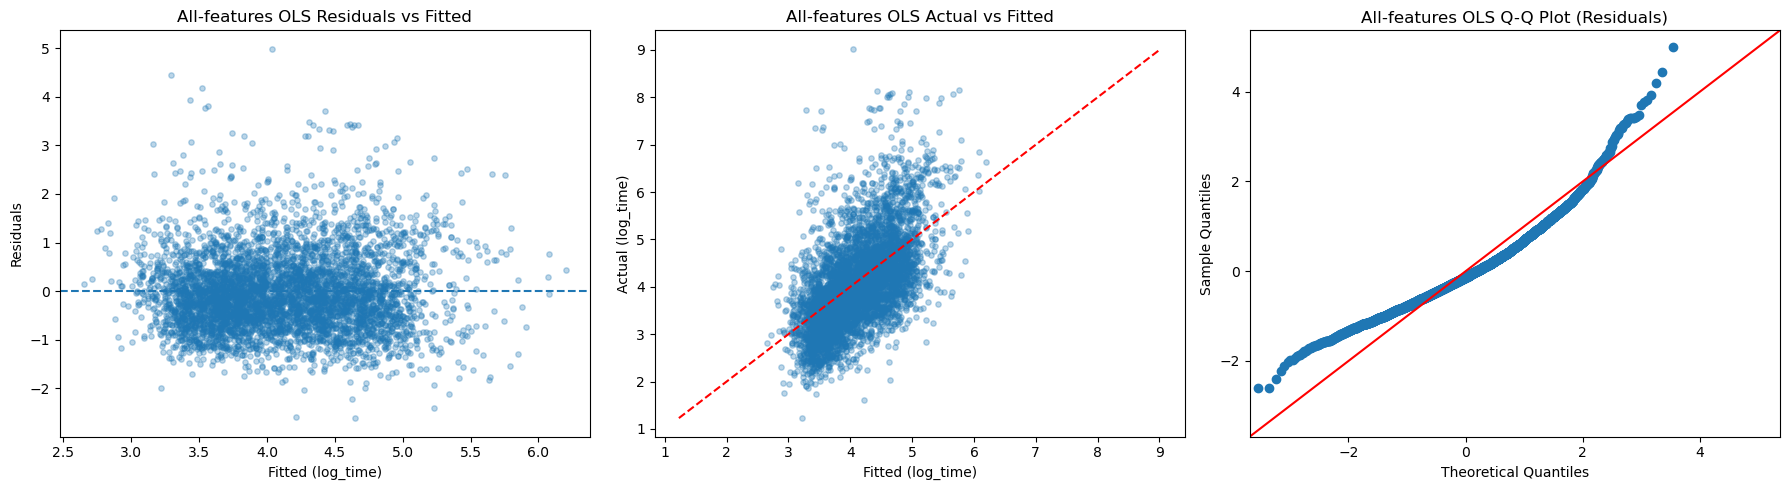

In [70]:
# ---------- Model 2: All-features OLS ----------
all_features = ["log_distance", "log_weight", "log_cube", "log_quantity",
                "WorkCode", "Aisle_top10", "Level_cat", "time_of_day"]

cat_cols_all = ["WorkCode", "Aisle_top10", "Level_cat", "time_of_day"]

X_train_a, y_train_a = build_Xy(train_df, all_features, cat_cols=cat_cols_all, drop_first=True, add_const=True)
X_test_a, y_test_a   = build_Xy(test_df,  all_features, cat_cols=cat_cols_all, drop_first=True, add_const=True)

X_test_a = X_test_a.reindex(columns=X_train_a.columns, fill_value=0)

model_all = fit_ols_qr(X_train_a, y_train_a)
print(model_all.summary())

pred_all, rmse_a, r2_a = eval_model(model_all, X_test_a, y_test_a, label="All-features OLS")

display(coef_table(model_all).head(60))
diag_plots(y_test_a, pred_all, title_prefix="All-features OLS")


In [71]:
# ---------- Model 3: Lasso regression ----------

features = [
    "log_distance",
    "log_weight",
    "log_cube",
    "log_quantity",
    "WorkCode",
    "Aisle_top10",
    "Level_cat",
    "time_of_day"
]

cat_cols = ["WorkCode", "Aisle_top10", "Level_cat", "time_of_day"]

def build_X(df):
    X = df[features].copy()
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    return X

X_train = build_X(train_df)
X_test  = build_X(test_df)

# align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train_df["log_time"].astype(float)
y_test  = test_df["log_time"].astype(float)


In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [73]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(
    cv=5,
    max_iter=5000,
    random_state=42,
    n_jobs=-1
)

lasso_cv.fit(X_train_scaled, y_train)

best_lambda = lasso_cv.alpha_
print("Best λ:", best_lambda)


Best λ: 0.005790960998951006


In [82]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=best_lambda*5, max_iter=5000)
lasso.fit(X_train_scaled, y_train)


Lasso(alpha=np.float64(0.02895480499475503), max_iter=5000)

In [83]:
coef_table = (
    pd.DataFrame({
        "feature": X_train.columns,
        "coefficient": lasso.coef_
    })
    .sort_values("coefficient", key=abs, ascending=False)
)

display(coef_table)


,feature,coefficient
0,log_distance,0.450235
3,log_quantity,0.188997
7,Aisle_top10_26,0.125341
1,log_weight,0.034962
15,Aisle_top10_Other,0.028425
6,Aisle_top10_25,-0.023912
11,Aisle_top10_39,-0.016828
8,Aisle_top10_30,0.007853
10,Aisle_top10_36,-0.003325
22,Level_cat_8,0.000000


In [84]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

pred_lasso = lasso.predict(X_test_scaled)

rmse_lasso = np.sqrt(mean_squared_error(y_test, pred_lasso))
r2_lasso = r2_score(y_test, pred_lasso)

print("Test RMSE:", rmse_lasso)
print("Test R²:", r2_lasso)


Test RMSE: 0.8032491862545378
Test R²: 0.3214674564476745


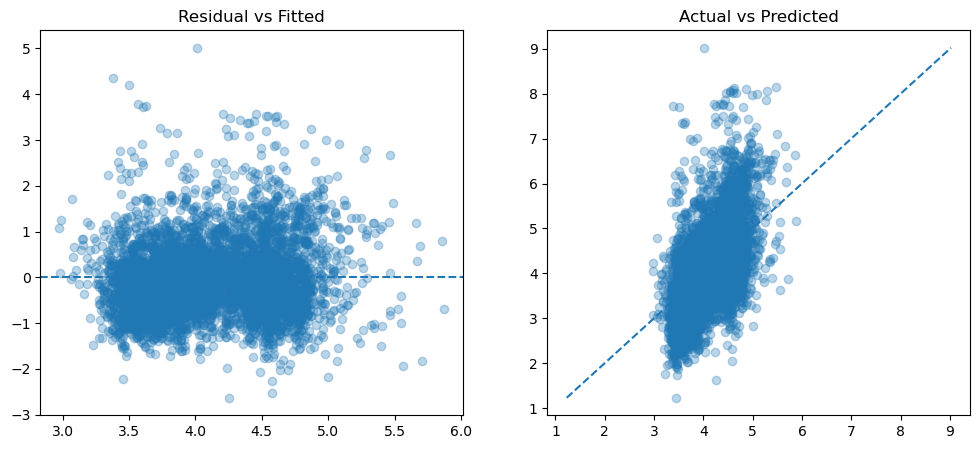

In [85]:
import matplotlib.pyplot as plt

resid = y_test - pred_lasso

fig, ax = plt.subplots(1,2, figsize=(12,5))

# residual vs fitted
ax[0].scatter(pred_lasso, resid, alpha=0.3)
ax[0].axhline(0, linestyle="--")
ax[0].set_title("Residual vs Fitted")

# actual vs predicted
ax[1].scatter(pred_lasso, y_test, alpha=0.3)
lims = [min(pred_lasso.min(), y_test.min()), max(pred_lasso.max(), y_test.max())]
ax[1].plot(lims, lims, "--")
ax[1].set_title("Actual vs Predicted")

plt.show()


In [86]:
selected = coef_table[coef_table["coefficient"] != 0]
print("Selected features:", len(selected))
display(selected)


Selected features: 9


,feature,coefficient
0,log_distance,0.450235
3,log_quantity,0.188997
7,Aisle_top10_26,0.125341
1,log_weight,0.034962
15,Aisle_top10_Other,0.028425
6,Aisle_top10_25,-0.023912
11,Aisle_top10_39,-0.016828
8,Aisle_top10_30,0.007853
10,Aisle_top10_36,-0.003325


In [87]:
# ---------- Model comparison ----------
summary = pd.DataFrame([
    {"model": "Simple OLS", "rmse_log": rmse_s, "r2": r2_s},
    {"model": "All-features OLS", "rmse_log": rmse_a, "r2": r2_a},
    {"model": "Lasso", "rmse_log": rmse_lasso, "r2": r2_lasso},
]).sort_values("rmse_log")

display(summary)


,model,rmse_log,r2
1,All-features OLS,0.793661,0.337570
2,Lasso,0.803249,0.321467
0,Simple OLS,0.842218,0.254034
